In [260]:
import unicodedata
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

In [275]:
# Abro datasets que necesito
driverStandings = pd.read_csv('../Hey-I-am-a-data-analyst/archive/archivef1/driverStandings.csv')
drivers = pd.read_csv('../Hey-I-am-a-data-analyst/archive/archivef1/drivers.csv')
races = pd.read_csv('../Hey-I-am-a-data-analyst/archive/archivef1/races.csv')
driverSalaries = pd.read_csv('../Hey-I-am-a-data-analyst/archive/archivef1/driverSalaries.csv') # Salarios escrapeados


df = pd.merge(driverStandings, drivers, on='driverId') # Cruzo drivers con driverStandings

full_name = df['forename'] +  ' ' + df['surname'] # Añado nombre completo de los pilotos
df['full_name'] = full_name # Añado nombre completo al dataframe

df = pd.merge(df, races, on='raceId') # Cruzo a con races
df = df[[ 'driverRef','position','name','full_name', 'date', 'number', 'nationality', 'dob']] # Selecciono columnas que me interesan

# renombro la columna 'Driver' para hacer merge con df
driverSalaries.rename(columns={'Driver':'full_name'}, inplace= True) 

# merge df con los driverSalaries
df = pd.merge(df, driverSalaries, on='full_name', how='left')

# Selecciono las columnas que necesito de nuevo
df = df[[ 'driverRef','position','name','full_name', 'date', 'number', 'Salary_2', 'nationality','dob']]

df.full_name.replace('Kimi R�_ikk̦nen','Kimi Raikkonen', inplace = True)
df.full_name.replace('Sergio P̩rez','Sergio Perez', inplace = True)

df

,driverRef,position,name,full_name,date,number,Salary_2,nationality,dob
0,hamilton,1,Australian Grand Prix,Lewis Hamilton,2008-03-16,44.0,30000000.0,British,07/01/1985
1,heidfeld,2,Australian Grand Prix,Nick Heidfeld,2008-03-16,NaN,NaN,German,10/05/1977
2,rosberg,3,Australian Grand Prix,Nico Rosberg,2008-03-16,6.0,NaN,German,27/06/1985
3,alonso,4,Australian Grand Prix,Fernando Alonso,2008-03-16,14.0,20000000.0,Spanish,29/07/1981
4,kovalainen,5,Australian Grand Prix,Heikki Kovalainen,2008-03-16,NaN,NaN,Finnish,19/10/1981
...,...,...,...,...,...,...,...,...,...
31721,leslie_johnson,23,British Grand Prix,Leslie Johnson,1950-05-13,NaN,NaN,British,22/03/1912
31722,martin,20,British Grand Prix,Eug̬ne Martin,1950-05-13,NaN,NaN,French,24/03/1915
31723,crossley,17,British Grand Prix,Geoff Crossley,1950-05-13,NaN,NaN,British,11/05/1921
31724,hampshire,9,British Grand Prix,David Hampshire,1950-05-13,NaN,NaN,British,29/12/1917


In [125]:
# Número de conductores únicos en cada tabla 
print('df unique drivers: ', df.full_name.nunique())
print('driverSalaries unique drivers: ', driverSalaries.full_name.nunique())
driverSalaries

df unique drivers:  835
driverSalaries unique drivers:  20


,Number,full_name,Team,Salary,Expiry date,Salary_2
0,1,Lewis Hamilton,Mercedes,$30m,2021,$30000000
1,2,Max Verstappen,Red Bull,$25m,2023,$25000000
2,3,Fernando Alonso,Alpine,$20m,2022,$20000000
3,4,Sebastian Vettel,Aston Martin,$15m,2021,$15000000
4,5,Daniel Ricciardo,McLaren,$15m,2022,$15000000
5,6,Charles Leclerc,Ferrari,$12m,2024,$12000000
6,7,Valtteri Bottas,Mercedes,$10m,2021,$10000000
7,8,Carlos Sainz,Ferrari,$10m,2022,$10000000
8,9,Lance Stroll,Aston Martin,$10m,Open,$10000000
9,10,Kimi Raikkonen,Alfa Romeo,$10m,2021,$10000000


In [127]:
# Los comunes son 11 y necesito que sean los 20
comun = set(driverSalaries.full_name).intersection(set(df.full_name))

no_comun = []
for i in comun:
    if i not in driverSalaries.full_name:
        no_comun.append(i)

no_comun = [ element for element in driverSalaries.full_name if element not in comun] 
no_comun

['Charles Leclerc',
 'Lando Norris',
 'Mick Schumacher',
 'Nikita Mazepin',
 'Nicholas Latifi',
 'George Russell',
 'Yuki Tsunoda']

In [147]:
x = np.array(df.Salary_2.isna())
np.sum(x)

30604

In [177]:
salaries = set(driverSalaries.Salary_2)
salaries

{500000,
 1000000,
 5000000,
 8000000,
 10000000,
 12000000,
 15000000,
 20000000,
 25000000,
 30000000}

In [182]:
salary_values = []
for i in df.Salary_2:
    if i > 0:
        salary_values.append(i)     
len(pilotosconsalario)

1122

In [304]:
filt = (df['Salary_2'] > 0)
df = df[filt]
df

,driverRef,position,name,full_name,date,number,Salary_2,nationality,dob
0,hamilton,1,Australian Grand Prix,Lewis Hamilton,2008-03-16,44.0,30000000.0,British,07/01/1985
3,alonso,4,Australian Grand Prix,Fernando Alonso,2008-03-16,14.0,20000000.0,Spanish,29/07/1981
8,hamilton,1,Malaysian Grand Prix,Lewis Hamilton,2008-03-23,44.0,30000000.0,British,07/01/1985
11,alonso,7,Malaysian Grand Prix,Fernando Alonso,2008-03-23,14.0,20000000.0,Spanish,29/07/1981
26,hamilton,3,Bahrain Grand Prix,Lewis Hamilton,2008-04-06,44.0,30000000.0,British,07/01/1985
...,...,...,...,...,...,...,...,...,...
7348,vettel,13,Australian Grand Prix,Sebastian Vettel,2009-03-29,5.0,15000000.0,German,03/07/1987
7350,alonso,3,Australian Grand Prix,Fernando Alonso,2005-03-06,14.0,20000000.0,Spanish,29/07/1981
7365,alonso,3,Australian Grand Prix,Fernando Alonso,2004-03-07,14.0,20000000.0,Spanish,29/07/1981
7379,alonso,5,Malaysian Grand Prix,Fernando Alonso,2004-03-21,14.0,20000000.0,Spanish,29/07/1981


AttributeError: module 'matplotlib.pyplot' has no attribute 'count'

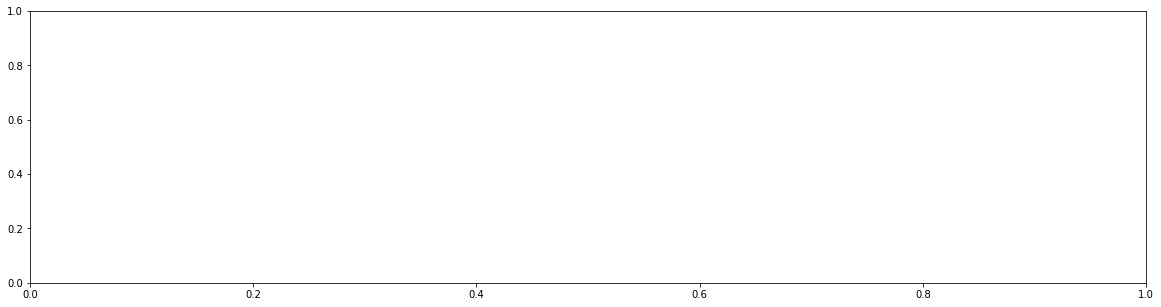

In [309]:
# Drivers with more data
fig, ax = plt.subplots(figsize=(20,5))
#plt.count( x =df.full_name[0:20], y =  df.Salary_2[0:20]);
sns.catplot(x="day", y="total_bill", data=tips)

In [292]:

def calculate_age(born):
    year = born[6:]
    return(int(2021-int(year)))
    
#calculate_age('29/12/1997')
#df.age = df['dob'].apply(index=1, func=(calculate_age(dob)))
#calculate_age('29/12/1997')


TypeError: 'float' object is not subscriptable